In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

## Overview

In this notebook, we want to provide a overview what HugeCTR framework is, its features and benefits. We will use HugeCTR to train a basic neural network architecture and deploy the saved model to Triton Inference Server. 

<b>Learning Objectives</b>:
* Adopt NVTabular workflow to provide input files to HugeCTR
* Define HugeCTR neural network architecture
* Train a deep learning model with HugeCTR
* Deploy HugeCTR to Triton Inference Server

### Why using HugeCTR?

HugeCTR is a GPU-accelerated recommender framework designed to distribute training across multiple GPUs and nodes and estimate Click-Through Rates (CTRs).<br>

HugeCTR offers multiple advantages to train deep learning recommender systems:
1. **Speed**: HugeCTR is a highly efficient framework written C++. We experienced upto 10x speed up. HugeCTR on a NVIDIA DGX A100 system proved to be the fastest commercially available solution for training the architecture Deep Learning Recommender Model (DLRM) developed by Facebook.
2. **Scale**: HugeCTR supports model parallel scaling. It distributes the large embedding tables over multiple GPUs or multiple nodes. 
3. **Easy-to-use**: Easy-to-use Python API similar to Keras. Examples for popular deep learning recommender systems architectures (Wide&Deep, DLRM, DCN, DeepFM) are available.

### Other Features of HugeCTR

HugeCTR is designed to scale deep learning models for recommender systems. It provides a list of other important features:
* Proficiency in oversubscribing models to train embedding tables with single nodes that don’t fit within the GPU or CPU memory (only required embeddings are prefetched from a parameter server per batch)
* Asynchronous and multithreaded data pipelines
* A highly optimized data loader.
* Supported data formats such as parquet and binary
* Integration with Triton Inference Server for deployment to production


### Getting Started

In this example, we will train a neural network with HugeCTR. We will use NVTabular for preprocessing.

#### Preprocessing and Feature Engineering with NVTabular

We use NVTabular for `Categorify` our categorical input columns.

In [2]:
import os, time
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# External dependencies
import time
import gc

import nvtabular as nvt
import cudf 
import numpy as np

from os import path
from sklearn.model_selection import train_test_split

We define our base directory, containing the data.

In [4]:
# path to store raw and preprocesses data
BASE_DIR = '/model/movie/data/'

If the data is not available in the base directory, we will download and unzip the data.

In [5]:
if not path.exists(BASE_DIR + 'ml-25m'):
    if not path.exists(BASE_DIR + 'ml-25m.zip'):
        os.system("wget http://files.grouplens.org/datasets/movielens/ml-25m.zip")
        os.system("mv ml-25m.zip " + BASE_DIR)
    os.system("unzip " + BASE_DIR + "ml-25m.zip -d " + BASE_DIR)

## Preparing the dataset with NVTabular

First, we take a look on the movie metadata.

We load the movie ratings.

In [6]:
ratings = cudf.read_csv(os.path.join(BASE_DIR, "ml-25m", "ratings.csv"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


We drop the timestamp column and split the ratings into training and test dataset. We use a simple random split.

In [7]:
ratings = ratings.drop('timestamp', axis=1)
train, valid = train_test_split(ratings, test_size=0.2, random_state=42)

In [8]:
train.head()

,userId,movieId,rating
19120594,124027,56587,4.0
15253127,98809,2641,2.5
12584278,81377,122886,4.5
18034326,116853,78499,4.5
18073299,117118,1302,2.5


We save our train and valid datasets as parquet files on disk, and below we will read them in while initializing the Dataset objects.

In [9]:
train.to_parquet(BASE_DIR + 'train.parquet')
valid.to_parquet(BASE_DIR + 'valid.parquet')

In [10]:
del train
del valid
gc.collect()

34

Let's define our categorical and label columns. Note that in that example wee do not have numerical columns.

In [11]:
CATEGORICAL_COLUMNS = ['userId', 'movieId']
LABEL_COLUMNS = ['rating']

Let's add Categorify op for our categorical features, userId, movieId.

In [12]:
cat_features = CATEGORICAL_COLUMNS >> nvt.ops.Categorify(cat_cache="device")

The ratings are on a scale between 1-5. We want to predict a binary target with 1 are all ratings >=4 and 0 are all ratings <=3. We use the LambdaOp for it.

In [13]:
ratings = nvt.ColumnGroup(['rating']) >> (lambda col: (col>3).astype('int8'))

We can visualize our calculation graph.

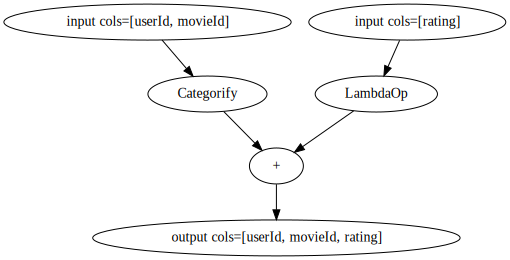

In [14]:
output = cat_features+ratings
(output).graph

We initialize our NVTabular workflow.

In [15]:
workflow = nvt.Workflow(output)

We initialize NVTabular Datasets, and use the part_size parameter, which defines the size read into GPU-memory at once, in nvt.Dataset.

In [16]:
train_dataset = nvt.Dataset(BASE_DIR + 'train.parquet', part_size='100MB')
valid_dataset = nvt.Dataset(BASE_DIR + 'valid.parquet', part_size='100MB')

First, we collect the training dataset statistics.

In [17]:
%%time

workflow.fit(train_dataset)

CPU times: user 1.1 s, sys: 407 ms, total: 1.51 s
Wall time: 1.54 s


This step is slightly different for HugeCTR. HugeCTR expect the categorical input columns as `int64` and continuous/label columns as `float32`  We can define output datatypes for our NVTabular workflow.

In [18]:
dict_dtypes={}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64
    
for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

Note: We do not have numerical output columns

In [19]:
if path.exists(BASE_DIR + 'train'): 
    !rm -r $BASE_DIR/train
if path.exists(BASE_DIR + 'valid'): 
    !rm -r $BASE_DIR/valid

In addition, we need to provide the data schema to the output calls. We need to define which output columns are `categorical`, `continuous` and which is the `label` columns. NVTabular will write metadata files, which HugeCTR requires to load the data and optimize training.

In [20]:
workflow.transform(train_dataset).to_parquet(output_path=BASE_DIR + 'train/', 
                                             shuffle=nvt.io.Shuffle.PER_PARTITION,
                                             cats=CATEGORICAL_COLUMNS,
                                             labels=LABEL_COLUMNS,
                                             dtypes=dict_dtypes
                                            )
workflow.transform(valid_dataset).to_parquet(output_path=BASE_DIR + 'valid/', 
                                             shuffle=False,
                                             cats=CATEGORICAL_COLUMNS,
                                             labels=LABEL_COLUMNS,
                                             dtypes=dict_dtypes
                                            )

## Scaling Accelerated training with HugeCTR

HugeCTR is a deep learning framework dedicated to recommendation systems. It is written in CUDA C++. As HugeCTR optimizes the training in CUDA++, we need to define the training pipeline and model architecture and execute it via the commandline. We will use the Python API, which is similar to Keras models.

HugeCTR has three main components:
* Solver: Specifies various details such as active GPU list, batchsize, and model_file
* Optimizer: Specifies the type of optimizer and its hyperparameters
* Model: Specifies training/evaluation data (and their paths), embeddings, and dense layers. Note that embeddings must precede the dense layers

**Solver**

Let's take a look on the parameter for the `Solver`. We should be familiar from other frameworks for the hyperparameter.

```
solver = hugectr.solver_parser_helper(
- vvgpu: GPU indices used in the training process, which has two levels. For example: [[0,1],[1,2]] indicates that two nodes are used in the first node. GPUs 0 and 1 are used while GPUs 1 and 2 are used for the second node. It is also possible to specify non-continuous GPU indices such as [0, 2, 4, 7]  
- max_iter: Total number of training iterations
- batchsize: Minibatch size used in training
- display: Intervals to print loss on the screen
- eval_interval: Evaluation interval in the unit of training iteration
- max_eval_batches: Maximum number of batches used in evaluation. It is recommended that the number is equal to or bigger than the actual number of bathces in the evaluation dataset.
If max_iter is used, the evaluation happens for max_eval_batches by repeating the evaluation dataset infinitely.
On the other hand, with num_epochs, HugeCTR stops the evaluation if all the evaluation data is consumed    
- batchsize_eval: Maximum number of batches used in evaluation. It is recommended that the number is equal to or
  bigger than the actual number of bathces in the evaluation dataset
- mixed_precision: Enables mixed precision training with the scaler specified here. Only 128,256, 512, and 1024 scalers are supported
)
```

**Optimizer**

The optimizer is the algorithm to update the model parameters. HugeCTR supports the common algorithms.


```
optimizer = CreateOptimizer(
- optimizer_type: Optimizer algorithm - Adam, MomentumSGD, Nesterov, and SGD 
- learning_rate: Learning Rate for optimizer
)
```

**Model**

We initialize the model with the solver and optimizer:

```
model = hugectr.Model(solver, optimizer)
```

We can add multiple layers to the model with `model.add` function. We will focus on:
- `Input` defines the input data
- `SparseEmbedding` defines the embedding layer
- `DenseLayer` defines dense layers, such as fully connected, ReLU, BatchNorm, etc.

**HugeCTR organizes the layers by names. For each layer, we define the input and output names.**

Input layer:

This layer is required to define the input data.

```
hugectr.Input(
    data_reader_type: Data format to read
    source: The training dataset file list.
    eval_source: The evaluation dataset file list.
    check_type: The data error detection machanism (Sum: Checksum, None: no detection).
    label_dim: Number of label columns
    label_name: Name of label columns in network architecture
    dense_dim: Number of continous columns
    dense_name: Name of contiunous columns in network architecture
    slot_size_array: The list of categorical feature cardinalities
    data_reader_sparse_param_array: Configuration how to read sparse data
    sparse_names: Name of sparse/categorical columns in network architecture
)
```

SparseEmbedding:

This layer defines embedding table

```
hugectr.SparseEmbedding(
    embedding_type: Different embedding options to distribute embedding tables 
    max_vocabulary_size_per_gpu: Maximum vocabulary size or cardinality across all the input features
    embedding_vec_size: Embedding vector size
    combiner: Intra-slot reduction op (0=sum, 1=average)
    sparse_embedding_name: Layer name
    bottom_name: Input layer names
)
```

DenseLayer:

This layer is copied to each GPU and is normally used for the MLP tower.

```
hugectr.DenseLayer(
    layer_type: Layer type, such as FullyConnected, Reshape, Concat, Loss, BatchNorm, etc.
    bottom_names: Input layer names
    top_names: Layer name
    ...: Depending on the layer type additional parameter can be defined
)
```

## Let's define our model

We walked through the documentation, but it is useful to understand the API. Finally, we can define our model. We will write the model to `./model.py` and execute it afterwards.

We need the cardinalities of each categorical feature to assign as `slot_size_array` in the model below.

In [21]:
from nvtabular.ops import get_embedding_sizes

embeddings = get_embedding_sizes(workflow)
print(embeddings)

{'movieId': (56586, 512), 'userId': (162542, 512)}


In addition, we need the total cardinalities to be assigned as `max_vocabulary_size_per_gpu` parameter.

In [22]:
total_cardinality = embeddings['movieId'][0] + embeddings['userId'][0] 
total_cardinality

219128

In [23]:
%%writefile './model.py'

import hugectr
from mpi4py import MPI

solver = hugectr.solver_parser_helper(vvgpu = [[0]],
                                      max_iter = 2000,
                                      batchsize = 2048,
                                      display = 100,
                                      eval_interval = 200,
                                      batchsize_eval = 2048,
                                      max_eval_batches = 160,
                                      i64_input_key = True,
                                      use_mixed_precision = False,
                                      repeat_dataset = True,
                                      snapshot = 1900
                                      )
optimizer = hugectr.optimizer.CreateOptimizer(
    optimizer_type = hugectr.Optimizer_t.Adam,
    use_mixed_precision = False
)
model = hugectr.Model(solver, optimizer)

model.add(
    hugectr.Input(
        data_reader_type = hugectr.DataReaderType_t.Parquet,
        source = "/model/movie/data/train/_file_list.txt",
        eval_source = "/model/movie/data/valid/_file_list.txt",
        check_type = hugectr.Check_t.Non,
        label_dim = 1, 
        label_name = "label",
        dense_dim = 0, 
        dense_name = "dense",
        slot_size_array = [56586, 162542],
        data_reader_sparse_param_array = [
            hugectr.DataReaderSparseParam(hugectr.DataReaderSparse_t.Distributed, 3, 1, 2)
        ],
        sparse_names = ["data1"]
    )
)
model.add(
    hugectr.SparseEmbedding(
        embedding_type = hugectr.Embedding_t.DistributedSlotSparseEmbeddingHash, 
        max_vocabulary_size_per_gpu = 219128,
        embedding_vec_size = 16,
        combiner = 0,
        sparse_embedding_name = "sparse_embedding1",
        bottom_name = "data1"
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type = hugectr.Layer_t.Reshape,
        bottom_names = ["sparse_embedding1"],
        top_names = ["reshape1"],
        leading_dim=32
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type = hugectr.Layer_t.InnerProduct,
        bottom_names = ["reshape1"], 
        top_names = ["fc1"],
        num_output=128
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type = hugectr.Layer_t.ReLU,
        bottom_names = ["fc1"], 
        top_names = ["relu1"],
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type = hugectr.Layer_t.InnerProduct,
        bottom_names = ["relu1"], 
        top_names = ["fc2"],
        num_output=128
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type = hugectr.Layer_t.ReLU,
        bottom_names = ["fc2"], 
        top_names = ["relu2"],
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type = hugectr.Layer_t.InnerProduct,
        bottom_names = ["relu2"], 
        top_names = ["fc3"],
        num_output=1
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type = hugectr.Layer_t.BinaryCrossEntropyLoss,
        bottom_names = ["fc3", "label"],
        top_names = ["loss"])
)
model.compile()
model.summary()
model.fit()

Overwriting ./model.py


In [24]:
!python model.py

===================================Model Init====================================
[08d20h25m32s][HUGECTR][INFO]: Global seed is 4040723604
[08d20h25m34s][HUGECTR][INFO]: Peer-to-peer access cannot be fully enabled.
Device 0: Tesla V100-DGXS-16GB
[08d20h25m34s][HUGECTR][INFO]: num of DataReader workers: 1
[08d20h25m34s][HUGECTR][INFO]: num_internal_buffers 1
[08d20h25m34s][HUGECTR][INFO]: num_internal_buffers 1
[08d20h25m34s][HUGECTR][INFO]: Vocabulary size: 219128
[08d20h25m34s][HUGECTR][INFO]: max_vocabulary_size_per_gpu_=219128
[08d20h25m36s][HUGECTR][INFO]: gpu0 start to init embedding
[08d20h25m36s][HUGECTR][INFO]: gpu0 init embedding done
==================================Model Summary==================================
Label Name                    Dense Name                    Sparse Name                   
label                         dense                         data1                         
--------------------------------------------------------------------------------
Lay

We trained our model.

After training terminates, we can see that two `.model` files are generated. We need to move them inside `1` folder under the `movielens_hugectr` folder. Let's create these folders.

In [25]:
!mkdir -p /model/movielens_hugectr/1

Now we move our saved `.model` files inside `1` folder.

In [26]:
!mv *.model /model/movielens_hugectr/1/

Note that these stored model files under the `movielens/1/` will be used in the inference. Now we have to create a JSON file for inference which has a similar configuration as our training file. We should remove the solver and optimizer clauses and add the inference clause in the JSON file. The paths of the stored dense model and sparse model(s) should be specified at dense_model_file and sparse_model_file within the inference clause. We need to make some modifications to data in the layers clause. Besides, we need to change the last layer from BinaryCrossEntropyLoss to Sigmoid. The rest of "layers" should be exactly the same as that in the training model.py file.

Now let's create a `movielens.json` file inside the `movielens/1` folder. We have already retrieved the cardinality of each categorical column using get_embedding_sizes function above. We will use these cardinalities below in the `movielens.json` file.

In [27]:
%%writefile '/model/movielens_hugectr/1/movielens.json'

{
   "inference": {
    "max_batchsize": 64,
    "hit_rate_threshold": 0.6,
    "dense_model_file": "/model/models/movielens/1/_dense_1900.model",
    "sparse_model_file": "/model/models/movielens/1/0_sparse_1900.model",
    "label": 1,
    "input_key_type": "I64"
  },
  "layers": [
    {
      "name": "data",
      "type": "Data",
      "format": "Parquet",
      "slot_size_array": [56586, 162542],
      "source": "/model/movie/data/train/_file_list.txt",
      "eval_source": "/model/movie/data/valid/_file_list.txt",
      "check": "Sum",
      "label": {
        "top": "label",
        "label_dim": 1
      },
      "dense": {
        "top": "dense",
        "dense_dim": 0
      },
      "sparse": [
        {
          "top": "data1",
          "type": "DistributedSlot",
          "max_feature_num_per_sample": 3,
          "slot_num": 2
        }
      ]
    },
    {
      "name": "sparse_embedding1",
      "type": "DistributedSlotSparseEmbeddingHash",
      "bottom": "data1",
      "top": "sparse_embedding1",
      "sparse_embedding_hparam": {
        "max_vocabulary_size_per_gpu": 219128,
        "embedding_vec_size": 16,
        "combiner": 0
      }
    },
    {
      "name": "reshape1",
      "type": "Reshape",
      "bottom": "sparse_embedding1",
      "top": "reshape1",
      "leading_dim": 32
    },
    {
      "name": "fc1",
      "type": "InnerProduct",
      "bottom": "reshape1",
      "top": "fc1",
      "fc_param": {
        "num_output": 128
      }
    },
    {
      "name": "relu1",
      "type": "ReLU",
      "bottom": "fc1",
      "top": "relu1"
    },
    {
      "name": "fc2",
      "type": "InnerProduct",
      "bottom": "relu1",
      "top": "fc2",
      "fc_param": {
        "num_output": 128
      }
    },
    {
      "name": "relu2",
      "type": "ReLU",
      "bottom": "fc2",
      "top": "relu2"
    },
    {
      "name": "fc3",
      "type": "InnerProduct",
      "bottom": "relu2",
      "top": "fc3",
      "fc_param": {
        "num_output": 1
      }
    },
    {
      "name": "sigmoid",
      "type": "Sigmoid",
      "bottom": "fc3",
      "top": "sigmoid"
    } 
  ]
}

Overwriting /model/movielens_hugectr/1/movielens.json


Now we can save our models to be deployed at the inference stage. To do so we will use `export_hugectr_ensemble` method below. With this method, we can generate the `config.pbtxt` files automatically for each model. In doing so, we should also create a `hugectr_params` dictionary, and define the parameters  like where the `movielens.json` file will be read, `slots` which corresponds to number of categorical features, `embedding_vector_size`, `max_nnz`, and `n_outputs` which is number of outputs.

The script below creates an ensemble triton server model where  

- `workflow` is the the nvtabular workflow used in preprocessing, 
- `hugectr_model_path` is the HugeCTR model that should be served. This path includes the `.model` files.
- `name` is the base name of the various triton models
- `output_path` is the path where is model will be saved to.

In [29]:
from nvtabular.inference.triton import export_hugectr_ensemble
hugectr_params = dict()
hugectr_params["config"] = "/model/models/movielens/1/movielens.json"
hugectr_params["slots"] = 2
hugectr_params["max_nnz"] = 2
hugectr_params["embedding_vector_size"] = 16
hugectr_params["n_outputs"] = 1
export_hugectr_ensemble(workflow=workflow, 
                        hugectr_model_path="/model/movielens_hugectr/1/",
                        hugectr_params=hugectr_params,
                        name="movielens", 
                        output_path="/model/models/", 
                        label_columns=["rating"], 
                        cats=CATEGORICAL_COLUMNS,
                        max_batch_size=64)